# **1. Install packages**

In [1]:
%%capture
!pip install segmentation-models-pytorch

In [3]:
%%capture
!pip install torchinfo

# **2. Import libraries**

In [4]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# train test split
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchinfo import summary
import segmentation_models_pytorch as smp
from torchvision import transforms

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings("ignore")

# **3. Load data**

In [6]:
!pip install -q opendatasets

import opendatasets as od
import pandas as pd

# {"username":"tsarkovmaksim","key":"74ef4b514ef55236e65eaa869060d3ac"}
od.download('https://www.kaggle.com/datasets/trainingdatapro/roads-segmentation-dataset/download?datasetVersionNumber=2') # insert ypu kaggle  username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tsarkovmaksim
Your Kaggle Key: ··········


100%|██████████| 16.0M/16.0M [00:00<00:00, 110MB/s] 

In [9]:
!pwd

/content


In [10]:
# Total Images
IMAGE_PATH = Path("/content/roads-segmentation-dataset/images")
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*.png"))
IMAGE_PATH_LIST = sorted(IMAGE_PATH_LIST)

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 31


In [11]:
# Total Masks
MASK_PATH = Path("/content/roads-segmentation-dataset/masks")
MASK_PATH_LIST = list(MASK_PATH.glob("*.png"))
MASK_PATH_LIST = sorted(MASK_PATH_LIST)

print(f'Total Masks = {len(MASK_PATH_LIST)}')

Total Masks = 31


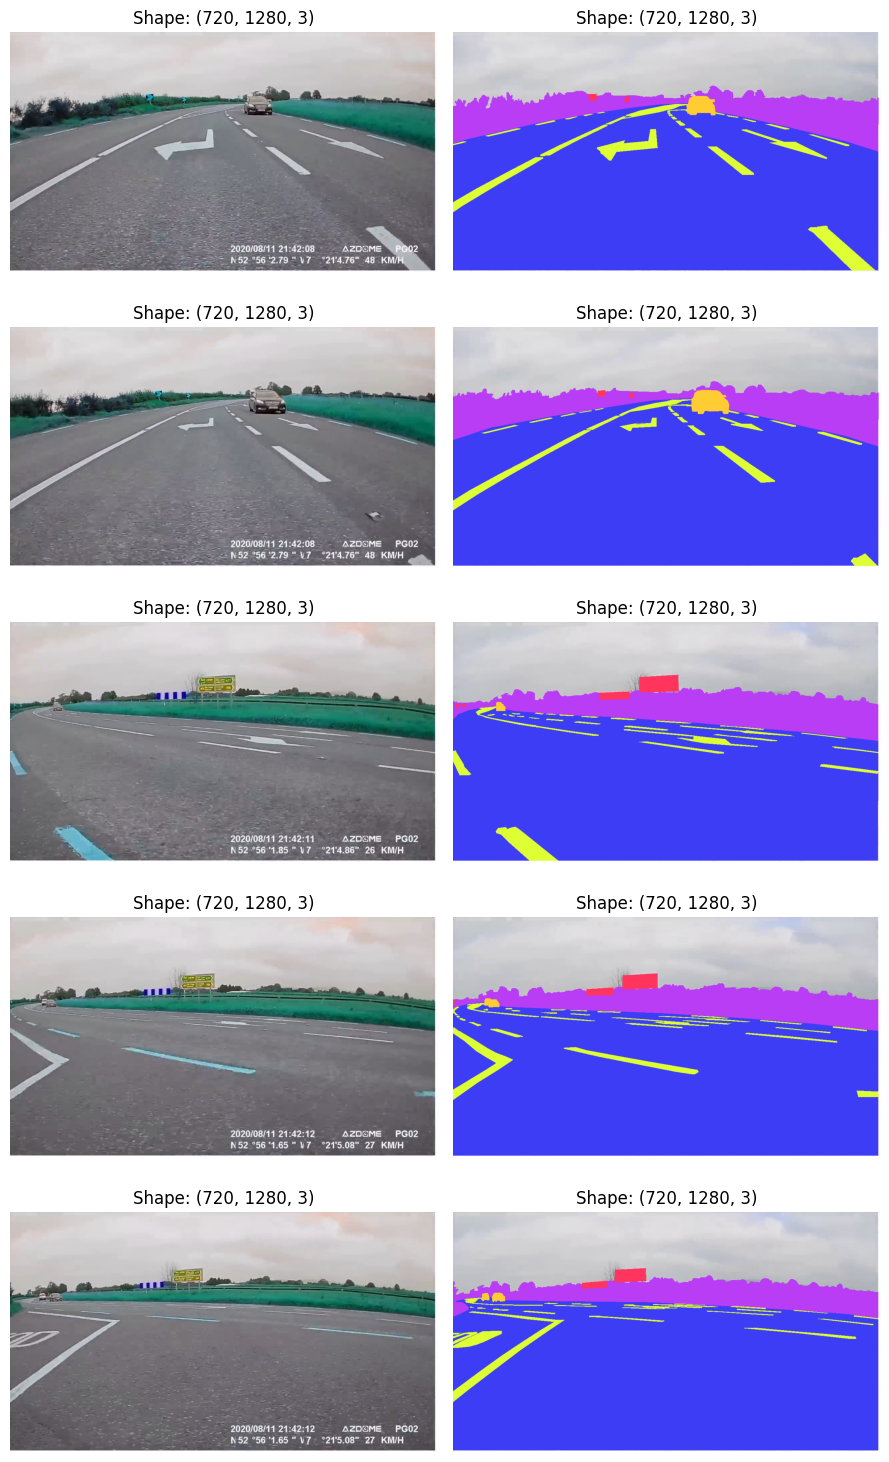

In [12]:
# We view some images with their respective masks.
fig,ax = plt.subplots(nrows = 5, ncols = 2, figsize = (9,15))

for i,(img_path, mk_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)):
    if i>4:
        break

    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(img_bgr)
    ax[i,0].axis('off')
    ax[i,0].set_title(f'Shape: {img_rgb.shape}')

    mask_bgr = cv2.imread(str(mk_path))
    mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    ax[i,1].imshow(mask_rgb)
    ax[i,1].axis('off')
    ax[i,1].set_title(f'Shape: {mask_rgb.shape}')

fig.tight_layout()
fig.show()

# **4. Preprocessing**

We create a **dataframe** where we store the **image paths** and their respective **mask**.

In [13]:
images_paths = [None] * len(IMAGE_PATH_LIST)
masks_paths = [None] * len(MASK_PATH_LIST)

for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)):
    images_paths[i] = img_path
    masks_paths[i] = mask_path

data = pd.DataFrame({'Image':images_paths, 'Mask':masks_paths})
data.head()

,Image,Mask
0,/content/roads-segmentation-dataset/images/0.png,/content/roads-segmentation-dataset/masks/0.png
1,/content/roads-segmentation-dataset/images/1.png,/content/roads-segmentation-dataset/masks/1.png
2,/content/roads-segmentation-dataset/images/10.png,/content/roads-segmentation-dataset/masks/10.png
3,/content/roads-segmentation-dataset/images/11.png,/content/roads-segmentation-dataset/masks/11.png
4,/content/roads-segmentation-dataset/images/12.png,/content/roads-segmentation-dataset/masks/12.png


We divide our dataframe into 3 data sets:
- **train = 70%**
- **validation = 15%**
- **test = 15%**

In [14]:
SEED = 42
# 0.7 - 0.15 - 0.15
data_train, data_rest = train_test_split(data,
                                         test_size = 0.3,
                                         random_state = SEED)

data_val, data_test = train_test_split(data_rest,
                                       test_size = 0.5,
                                       random_state = SEED)

Мы создаем **словарь**, в котором сохраняем **цвет** и соответствующий **id** каждого класса.

In [15]:
color2id = {(184, 61, 245): 0, # #b83df5: backgroud
            (255, 53, 94):1, # #ff355e: road_sign
            (255, 204, 51):2, # #ffcc33: car
            (221, 255, 51):3, # #ddff33: marking
            (61,61, 245):4} # #3d3df5: road_surface

In [16]:
# We define a function to create an array of id's that will help us calculate the metrics and the loss.
def mapping_color(img:Image, color2id:dict):

    image = np.array(img)

    height,width,_ = image.shape
    output_matrix = np.full(shape = (height, width), fill_value = -1, dtype = np.int32)

    for h in range(height):
        for w in range(width):
            color_pixel = tuple(image[h,w,:])

            if color_pixel in color2id:
                output_matrix[h,w] = color2id[color_pixel]


    return output_matrix

Теперь мы создаем наш **Dataset**, а затем **DataLoader**.

- **Dataset**

In [17]:
class CustomDataset(Dataset):
    def __init__(self, data:pd.DataFrame, color2id:dict, image_transforms, mask_transforms):
        self.data = data
        self.color2id = color2id
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_path = data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)

        mask_path = data.iloc[idx, 1]
        mask = Image.open(mask_path).convert("RGB")
        mask = self.mask_transforms(mask)
        mask = mapping_color(mask, self.color2id)

        return image, mask


In [18]:
RESIZE = (512, 512)

image_transforms = transforms.Compose([transforms.Resize(RESIZE),
                                       transforms.ToTensor()])

mask_transforms = transforms.Compose([transforms.Resize(RESIZE)])

In [19]:
train_dataset = CustomDataset(data_train,
                              color2id,
                              image_transforms,
                              mask_transforms)

val_dataset = CustomDataset(data_val,
                            color2id,
                            image_transforms,
                            mask_transforms)

- **DataLoader**

In [20]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = 1,
                            shuffle = True,
                            num_workers = NUM_WORKERS)

In [21]:
# We visualize the dimensions of a batch.
batch_images, batch_masks = next(iter(train_dataloader))

batch_images.shape, batch_masks.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 512, 512]))

# **5. Model**

In [22]:
# GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [23]:
# Define Model
model = smp.Unet(classes = 5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 129MB/s]


In [24]:
# We visualize the architecture of our model.
summary(model = model,
        col_width = 17,
        input_size = [1,3,512,512],
        col_names = ['input_size','output_size','num_params','trainable'],
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 512, 512]  [1, 5, 512, 512]  --                True
├─ResNetEncoder (encoder)                          [1, 3, 512, 512]  [1, 3, 512, 512]  --                True
│    └─Conv2d (conv1)                              [1, 3, 512, 512]  [1, 64, 256, 256] 9,408             True
│    └─BatchNorm2d (bn1)                           [1, 64, 256, 256] [1, 64, 256, 256] 128               True
│    └─ReLU (relu)                                 [1, 64, 256, 256] [1, 64, 256, 256] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 256, 256] [1, 64, 128, 128] --                --
│    └─Sequential (layer1)                         [1, 64, 128, 128] [1, 64, 128, 128] --                True
│    │    └─BasicBlock (0)                         [1, 64, 128, 128] [1, 64, 128, 128] 73,984            True
│    │   

In [25]:
# We freeze the encoder layer.
for param in model.encoder.parameters():
    param.requires_grad = False

In [26]:
# We see again if the encoder layer freezes.
summary(model = model,
        col_width = 17,
        input_size = [1,3,512,512],
        col_names = ['input_size','output_size','num_params','trainable'],
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 512, 512]  [1, 5, 512, 512]  --                Partial
├─ResNetEncoder (encoder)                          [1, 3, 512, 512]  [1, 3, 512, 512]  --                False
│    └─Conv2d (conv1)                              [1, 3, 512, 512]  [1, 64, 256, 256] (9,408)           False
│    └─BatchNorm2d (bn1)                           [1, 64, 256, 256] [1, 64, 256, 256] (128)             False
│    └─ReLU (relu)                                 [1, 64, 256, 256] [1, 64, 256, 256] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 256, 256] [1, 64, 128, 128] --                --
│    └─Sequential (layer1)                         [1, 64, 128, 128] [1, 64, 128, 128] --                False
│    │    └─BasicBlock (0)                         [1, 64, 128, 128] [1, 64, 128, 128] (73,984)          False
│

Мы определяем **функцию потерь** и **оптимизатор**.


In [27]:
loss_fn = smp.losses.DiceLoss(mode = "multiclass", classes = 5, ignore_index = -1)
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

Мы определяем некоторые функции для выполнения обучения и другие для прогнозирования новых данных:

- **Ранняя остановка** - EarlyStopping
- **train_step**
- **val_step**

In [28]:
class EarlyStopping:
    def __init__(self, patience:int = 5, delta:float = 0.0001, path = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)

        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [29]:
early_stopping = EarlyStopping(patience = 20, delta = 0.)

In [30]:
def train_step(model, dataloader,
               loss_fn, optimizer):

    model.train()

    train_loss = 0.
    train_iou = 0.

    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32)
        y = y.to(device = DEVICE, dtype = torch.long)

        optimizer.zero_grad()

        pred_logit = model(X)
        loss = loss_fn(pred_logit, y)
        train_loss = loss.item()

        loss.backward()
        optimizer.step()

        pred_prob = pred_logit.softmax(dim = 1)
        pred_class = pred_prob.argmax(dim = 1)

        tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().cpu().long(),
                                            target = y.cpu(),
                                            mode = "multiclass",
                                            ignore_index = -1,
                                            num_classes = 5)

        train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")

    train_loss = train_loss / len(dataloader)
    train_iou = train_iou / len(dataloader)

    return train_loss, train_iou

In [31]:
def val_step(model, dataloader,
             loss_fn):

    model.eval()

    val_loss = 0.
    val_iou = 0.

    with torch.inference_mode():

        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)

            pred_logit = model(X)
            loss = loss_fn(pred_logit, y)
            val_loss = loss.item()

            pred_prob = pred_logit.softmax(dim = 1)
            pred_class = pred_prob.argmax(dim = 1)

            tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().cpu().long(),
                                                target = y.cpu(),
                                                mode = "multiclass",
                                                ignore_index = -1,
                                                num_classes = 5)

            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")


    val_loss = val_loss / len(dataloader)
    val_iou = val_iou / len(dataloader)

    return val_loss, val_iou

In [32]:
def train(model, train_dataloader,
          val_dataloader, loss_fn, optimizer,
          early_stopping, epochs:int = 10):

    results = {'train_loss':[], 'train_iou':[], 'val_loss':[], 'val_iou':[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_iou = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)

        val_loss, val_iou = val_step(model = model,
                                     dataloader = val_dataloader,
                                     loss_fn = loss_fn)

        print(f'Epoch: {epoch + 1} | ',
              f'Train Loss: {train_loss:.4f} | ',
              f'Train IOU: {train_iou:.4f} | ',
              f'Val Loss: {val_loss:.4f} | ',
              f'Val IOU: {val_iou:.4f}')


        early_stopping(val_loss, model)

        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break

        results['train_loss'].append(train_loss)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_iou'].append(val_iou)

    return results

In [33]:
# Training
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE),
                train_dataloader,
                val_dataloader,
                loss_fn,
                optimizer,
                early_stopping,
                EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.0282 |  Train IOU: 0.7800 |  Val Loss: 0.1100 |  Val IOU: 0.8039
Epoch: 2 |  Train Loss: 0.0187 |  Train IOU: 0.9097 |  Val Loss: 0.0552 |  Val IOU: 0.9417
Epoch: 3 |  Train Loss: 0.0182 |  Train IOU: 0.9338 |  Val Loss: 0.0492 |  Val IOU: 0.9539
Epoch: 4 |  Train Loss: 0.0125 |  Train IOU: 0.9466 |  Val Loss: 0.0499 |  Val IOU: 0.9541
Epoch: 5 |  Train Loss: 0.0115 |  Train IOU: 0.9448 |  Val Loss: 0.0488 |  Val IOU: 0.9627
Epoch: 6 |  Train Loss: 0.0104 |  Train IOU: 0.9545 |  Val Loss: 0.0220 |  Val IOU: 0.9770
Epoch: 7 |  Train Loss: 0.0058 |  Train IOU: 0.9336 |  Val Loss: 0.0169 |  Val IOU: 0.9715
Epoch: 8 |  Train Loss: 0.0038 |  Train IOU: 0.9498 |  Val Loss: 0.0553 |  Val IOU: 0.9523
Epoch: 9 |  Train Loss: 0.0123 |  Train IOU: 0.9487 |  Val Loss: 0.0439 |  Val IOU: 0.9683
Epoch: 10 |  Train Loss: 0.0133 |  Train IOU: 0.9508 |  Val Loss: 0.0629 |  Val IOU: 0.9335
Epoch: 11 |  Train Loss: 0.0107 |  Train IOU: 0.9674 |  Val Loss: 0.0234 |  Val IOU: 0.95

In [34]:
# We define a function to visualize the evolution of the metric and the loss during training.
def loss_and_metric_plot(results:dict):
    training_loss = results['train_loss']
    valid_loss = results['val_loss']

    training_iou = results['train_iou']
    valid_iou = results['val_iou']

    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
    axes = axes.flat

    axes[0].plot(range(len(training_loss)), training_loss)
    axes[0].plot(range(len(valid_loss)), valid_loss)
    axes[0].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_title("Dice Loss", fontsize = 14, fontweight = "bold", color = "blue")

    axes[1].plot(range(len(training_iou)), training_iou)
    axes[1].plot(range(len(valid_iou)), valid_iou)
    axes[1].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_ylabel("score", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_title("IOU", fontsize = 14, fontweight = "bold", color = "red")

    fig.tight_layout()
    fig.show()

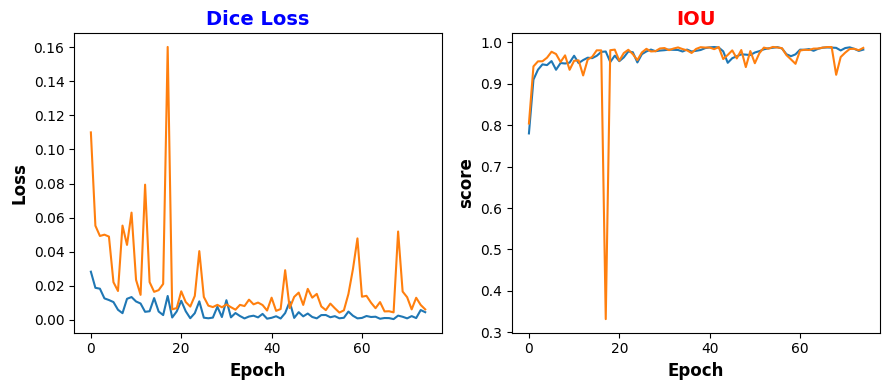

In [35]:
loss_and_metric_plot(RESULTS)

# **6. Evaluation metric**

In [36]:
def predictions(test_dataloader:torch.utils.data.DataLoader, best_model:str):

    checkpoint = torch.load(best_model)

    loaded_model = smp.Unet(encoder_name = "resnet34", encoder_weights = None, classes = 5)

    loaded_model.load_state_dict(checkpoint)

    loaded_model.to(device = DEVICE)

    loaded_model.eval()

    pred_mask_test = []

    with torch.inference_mode():
        for X,_ in tqdm(test_dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            logit_mask = loaded_model(X)
            prob_mask = logit_mask.softmax(dim = 1)
            pred_mask = prob_mask.argmax(dim = 1)
            pred_mask_test.append(pred_mask.detach().cpu())

    pred_mask_test = torch.cat(pred_mask_test)

    return pred_mask_test

- **Predictions**

Just as we did with our training and validation data we are going to create our **Dataset** and **DataLoader** for our **test set**.

In [37]:
test_dataset = CustomDataset(data_test, color2id, image_transforms, mask_transforms)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

In [38]:
pred_mask_test = predictions(test_dataloader, "/content/best_model.pth")

  0%|          | 0/5 [00:00<?, ?it/s]

In [39]:
# We are going to create our tensors so we can plot later.
IMAGE_TEST = []
MASK_TEST = []

for img,mask in test_dataloader:
    IMAGE_TEST.append(img)
    MASK_TEST.append(mask)

IMAGE_TEST = torch.cat(IMAGE_TEST)

MASK_TEST = torch.cat(MASK_TEST)

- **IOU**

In [40]:
TP, FP, FN, TN = smp.metrics.get_stats(output = pred_mask_test.long(),
                                       target = MASK_TEST.long(),
                                       mode = "multiclass",
                                       ignore_index = -1,
                                       num_classes = 5)

In [41]:
iou_test = smp.metrics.iou_score(TP, FP, FN, TN, reduction = "micro")
print(f'IOU Test = {iou_test:.4f}')

IOU Test = 0.9872


# **7. Display mask test**

Now we want to visualize the predictions versus the actual masks, for this we are going to create a **dictionary** called **`id2color` to obtain the color according to the `id`**.

In [42]:
id2color = {0: (184, 61, 245), # background
            1: (255, 53, 94), # road_sign
            2: (255, 204, 51), # car
            3: (221, 255, 51), # marking
            4: (61,61, 245)} # road_surface

**Now we are going to transform the matrices that contained the id's to the predicted mask with their respective colors.**

In [43]:
total_mask_output = []

for i,mask_pred in enumerate(pred_mask_test):

    # We extract the height and width of the mask.
    height,width = mask_pred.shape

    # We are going to create a Boolean array to filter the values -1, which is that id that does not belong to any class.
    mask_original = MASK_TEST[i]
    ignore = mask_original == -1 # id: -1

    mask_predicted = torch.where(ignore, -1, mask_pred)
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)

    for h in range(height):
        for w in range(width):
            idcolor = int(mask_predicted[h,w])

            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])

    total_mask_output.append(mask_zeros)

**We are going to do the same for the real masks**.

In [44]:
total_mask_test = []

for mask_tst in MASK_TEST:

    # Extraemos el height y width de la máscara.
    height,width = mask_tst.shape

    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)

    for h in range(height):
        for w in range(width):
            idcolor = int(mask_tst[h,w])

            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])

    total_mask_test.append(mask_zeros)

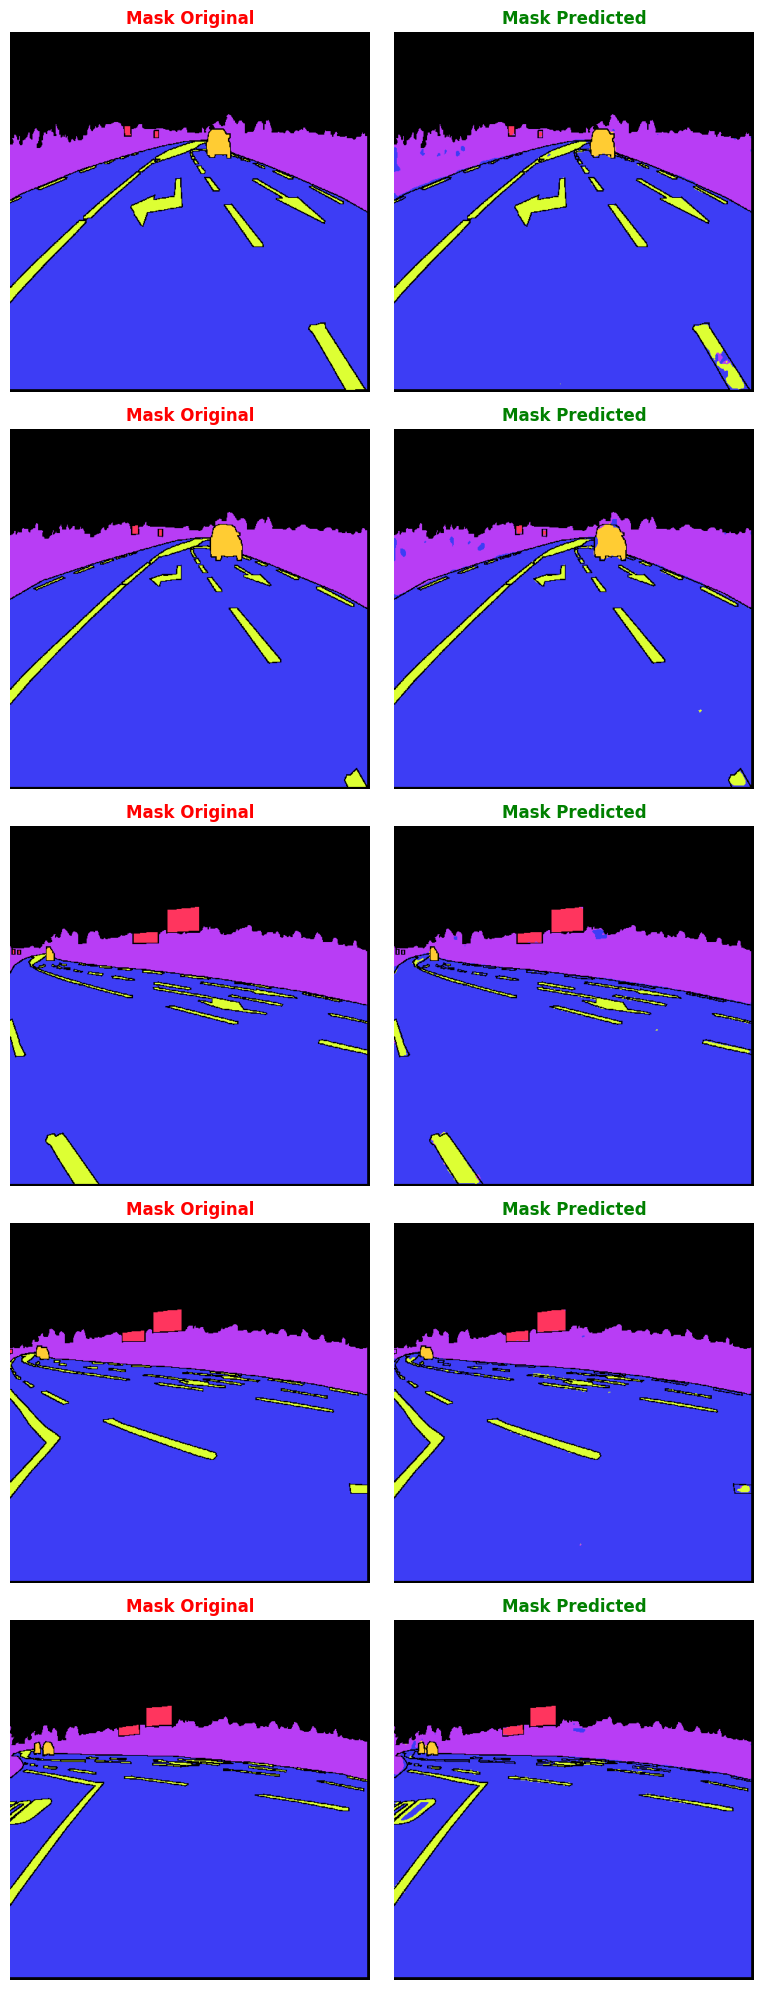

In [45]:
# Finally, we visualize the predicted mask and the actual mask.
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (8,20))

for i,(mk_out,mk_test) in enumerate(zip(total_mask_output, total_mask_test)):

    mask_test = mk_test.numpy()
    ax[i,0].imshow(mask_test)
    ax[i,0].set_title("Mask Original", fontsize = 12, fontweight = "bold", color = "red")
    ax[i,0].axis('off')

    mask_out = mk_out.numpy()
    ax[i,1].imshow(mask_out)
    ax[i,1].set_title("Mask Predicted", fontsize = 12, fontweight = "bold", color = "green")
    ax[i,1].axis('off')

fig.tight_layout()
fig.show()